# Feature Engineering

Este notebook tem como objetivo preparar o conjunto de dados para a etapa de modelagem preditiva, realizando transformações necessárias nas variáveis, com base nos insights obtidos na análise exploratória. As decisões adotadas visam aumentar a robustez estatística, reduzir ruído e preservar o significado semântico das variáveis.


In [33]:
# Importação do arquivo tratado no EDA (Analise Exploratória de Dados)

from pathlib import Path
import pandas as pd

base = Path(r"C:\projetos\fase4")

df_fe_obesidade = pd.read_csv(
    base / "data" / "processed" / "obesity_processed_eda.csv"
)

df_fe_obesidade.shape



(2084, 18)

In [34]:
# Verificação rápidade de duplicidades e valores nulos

print("Duplicados:", df_fe_obesidade.duplicated().sum())
print("Nulos:", df_fe_obesidade.isna().sum().sum())


Duplicados: 0
Nulos: 0


In [35]:
# Realiza cópia do DF para trabalhar e não sujar o arquivo carregado

df_model = df_fe_obesidade.copy()

df_model.shape


(2084, 18)

In [36]:
df_model.head()

,sexo,idade,altura,peso,historico_familiar,ingere_alim_calorico,ingere_vegetais,qtd_refeicao_principal,come_entre_refeicao,fumante,consumo_agua_litro,monitora_calorias,freq_atividade_fisica,tempo_uso_eletronico,frequencia_consumo_alcool,meio_de_transporte,nivel_obesidade,freq_ativ_fisica_texto
0,Feminino,21.0,1.62,64.0,Sim,Não,2.0,3.0,Às Vezes,Não,2.0,Não,0.0,1.0,Não,Transporte Público,Peso Normal,Nenhuma atividade
1,Feminino,21.0,1.52,56.0,Sim,Não,3.0,3.0,Às Vezes,Sim,3.0,Sim,3.0,0.0,Às Vezes,Transporte Público,Peso Normal,5x ou mais
2,Masculino,23.0,1.80,77.0,Sim,Não,2.0,3.0,Às Vezes,Não,2.0,Não,2.0,1.0,Frequentemente,Transporte Público,Peso Normal,3–4x por semana
3,Masculino,27.0,1.80,87.0,Não,Não,3.0,3.0,Às Vezes,Não,2.0,Não,2.0,0.0,Frequentemente,A Pé,Sobrepeso Nível I,3–4x por semana
4,Masculino,22.0,1.78,89.8,Não,Não,2.0,1.0,Às Vezes,Não,2.0,Não,0.0,0.0,Às Vezes,Transporte Público,Sobrepeso Nível II,Nenhuma atividade


In [37]:
# Excluir a coluna de frequencia de atividade física em texto, pois já temos ela em formato númerico

df_model = df_model.drop(columns=["freq_ativ_fisica_texto"])


In [38]:
# Tratar classes raras (decisões do EDA) - Frequência de consumo de álcool
# Sempre → agrupar em Frequentemente

df_model["frequencia_consumo_alcool"] = (
    df_model["frequencia_consumo_alcool"]
    .replace({"Sempre": "Frequentemente"})
)



In [39]:
# Tratar classes raras (decisões do EDA) - Meio de transporte
# Realizar Agrupamento semântico e estatístico: Motorizado e Não Motorizado

df_model["meio_de_transporte"] = df_model["meio_de_transporte"].replace({
    "Carro": "Motorizado",
    "Moto": "Motorizado",
    "Transporte Público": "Motorizado",
    "A Pé": "Nao_Motorizado",
    "Bicicleta": "Nao_Motorizado"
})



In [40]:
# Tratar classes raras (decisões do EDA) - Comer entre refeições
# Realizar Agrupamento por intensidade: Baixa, média, alta

df_model["come_entre_refeicao"] = df_model["come_entre_refeicao"].replace({
    "Não": "Baixa",
    "Às Vezes": "Media",
    "Frequentemente": "Alta",
    "Sempre": "Alta"
})


In [41]:
df_model.head()

,sexo,idade,altura,peso,historico_familiar,ingere_alim_calorico,ingere_vegetais,qtd_refeicao_principal,come_entre_refeicao,fumante,consumo_agua_litro,monitora_calorias,freq_atividade_fisica,tempo_uso_eletronico,frequencia_consumo_alcool,meio_de_transporte,nivel_obesidade
0,Feminino,21.0,1.62,64.0,Sim,Não,2.0,3.0,Media,Não,2.0,Não,0.0,1.0,Não,Motorizado,Peso Normal
1,Feminino,21.0,1.52,56.0,Sim,Não,3.0,3.0,Media,Sim,3.0,Sim,3.0,0.0,Às Vezes,Motorizado,Peso Normal
2,Masculino,23.0,1.80,77.0,Sim,Não,2.0,3.0,Media,Não,2.0,Não,2.0,1.0,Frequentemente,Motorizado,Peso Normal
3,Masculino,27.0,1.80,87.0,Não,Não,3.0,3.0,Media,Não,2.0,Não,2.0,0.0,Frequentemente,Nao_Motorizado,Sobrepeso Nível I
4,Masculino,22.0,1.78,89.8,Não,Não,2.0,1.0,Media,Não,2.0,Não,0.0,0.0,Às Vezes,Motorizado,Sobrepeso Nível II


In [42]:
# Codificação de variáveis binárias (converte texto em números nas colunas que só possuem duas opções - sexo, historico_familiar, ingere_alim_calorico, fumante e monitora_calorias)
# Modeslo de ML não trabalham com texto diretamente Então é necessário “codificar” as respostas para números

# Dicionário
bin_map = {
    "Sim": 1,
    "Não": 0,
    "Masculino": 1,
    "Feminino": 0,
    "Motorizado": 1,
    "Nao_Motorizado": 0
}

# Colunas afetadas
cols_binarias = [
    "sexo",
    "historico_familiar",
    "ingere_alim_calorico",
    "fumante",
    "monitora_calorias",
    "meio_de_transporte"
]

for c in cols_binarias:
    df_model[c] = df_model[c].map(bin_map)


In [43]:
df_model.head()

,sexo,idade,altura,peso,historico_familiar,ingere_alim_calorico,ingere_vegetais,qtd_refeicao_principal,come_entre_refeicao,fumante,consumo_agua_litro,monitora_calorias,freq_atividade_fisica,tempo_uso_eletronico,frequencia_consumo_alcool,meio_de_transporte,nivel_obesidade
0,0,21.0,1.62,64.0,1,0,2.0,3.0,Media,0,2.0,0,0.0,1.0,Não,1,Peso Normal
1,0,21.0,1.52,56.0,1,0,3.0,3.0,Media,1,3.0,1,3.0,0.0,Às Vezes,1,Peso Normal
2,1,23.0,1.80,77.0,1,0,2.0,3.0,Media,0,2.0,0,2.0,1.0,Frequentemente,1,Peso Normal
3,1,27.0,1.80,87.0,0,0,3.0,3.0,Media,0,2.0,0,2.0,0.0,Frequentemente,0,Sobrepeso Nível I
4,1,22.0,1.78,89.8,0,0,2.0,1.0,Media,0,2.0,0,0.0,0.0,Às Vezes,1,Sobrepeso Nível II


In [44]:
# Codificação de variáveis ordinais

alcool_ord = {"Não": 0, "Às Vezes": 1, "Frequentemente": 2}
df_model["frequencia_consumo_alcool"] = (
    df_model["frequencia_consumo_alcool"].map(alcool_ord)
)

come_ord = {"Baixa": 0, "Media": 1, "Alta": 2}
df_model["come_entre_refeicao"] = (
    df_model["come_entre_refeicao"].map(come_ord)
)


In [45]:
# Checagem de integridade pós-transformação

print("Shape:", df_model.shape)
print("Nulos totais:", df_model.isna().sum().sum())
print("Duplicados:", df_model.duplicated().sum())

df_model.info()
df_model.head()


Shape: (2084, 17)
Nulos totais: 0
Duplicados: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sexo                       2084 non-null   int64  
 1   idade                      2084 non-null   float64
 2   altura                     2084 non-null   float64
 3   peso                       2084 non-null   float64
 4   historico_familiar         2084 non-null   int64  
 5   ingere_alim_calorico       2084 non-null   int64  
 6   ingere_vegetais            2084 non-null   float64
 7   qtd_refeicao_principal     2084 non-null   float64
 8   come_entre_refeicao        2084 non-null   int64  
 9   fumante                    2084 non-null   int64  
 10  consumo_agua_litro         2084 non-null   float64
 11  monitora_calorias          2084 non-null   int64  
 12  freq_atividade_fisica      2084 non-null   float64
 13  

,sexo,idade,altura,peso,historico_familiar,ingere_alim_calorico,ingere_vegetais,qtd_refeicao_principal,come_entre_refeicao,fumante,consumo_agua_litro,monitora_calorias,freq_atividade_fisica,tempo_uso_eletronico,frequencia_consumo_alcool,meio_de_transporte,nivel_obesidade
0,0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,1,Peso Normal
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,1,Peso Normal
2,1,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,1,Peso Normal
3,1,27.0,1.80,87.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,0,Sobrepeso Nível I
4,1,22.0,1.78,89.8,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,1,Sobrepeso Nível II


In [46]:
# Ajuste de algumas colunas de float64 para int64

cols_float = [
    "ingere_vegetais",
    "qtd_refeicao_principal",
    "consumo_agua_litro",
    "freq_atividade_fisica",
    "tempo_uso_eletronico"
]

df_model[cols_float] = df_model[cols_float].astype(int)

# Checagem de integridade pós-transformação

df_model.info()
df_model.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sexo                       2084 non-null   int64  
 1   idade                      2084 non-null   float64
 2   altura                     2084 non-null   float64
 3   peso                       2084 non-null   float64
 4   historico_familiar         2084 non-null   int64  
 5   ingere_alim_calorico       2084 non-null   int64  
 6   ingere_vegetais            2084 non-null   int64  
 7   qtd_refeicao_principal     2084 non-null   int64  
 8   come_entre_refeicao        2084 non-null   int64  
 9   fumante                    2084 non-null   int64  
 10  consumo_agua_litro         2084 non-null   int64  
 11  monitora_calorias          2084 non-null   int64  
 12  freq_atividade_fisica      2084 non-null   int64  
 13  tempo_uso_eletronico       2084 non-null   int64

,sexo,idade,altura,peso,historico_familiar,ingere_alim_calorico,ingere_vegetais,qtd_refeicao_principal,come_entre_refeicao,fumante,consumo_agua_litro,monitora_calorias,freq_atividade_fisica,tempo_uso_eletronico,frequencia_consumo_alcool,meio_de_transporte,nivel_obesidade
0,0,21.0,1.62,64.0,1,0,2,3,1,0,2,0,0,1,0,1,Peso Normal
1,0,21.0,1.52,56.0,1,0,3,3,1,1,3,1,3,0,1,1,Peso Normal
2,1,23.0,1.80,77.0,1,0,2,3,1,0,2,0,2,1,2,1,Peso Normal
3,1,27.0,1.80,87.0,0,0,3,3,1,0,2,0,2,0,2,0,Sobrepeso Nível I
4,1,22.0,1.78,89.8,0,0,2,1,1,0,2,0,0,0,1,1,Sobrepeso Nível II


## Separar target e features

In [47]:

classes_obeso = {
    "Obesidade Grau I",
    "Obesidade Grau II",
    "Obesidade Grau III"
}

df_model_final = df_model.copy()

df_model_final["nivel_obesidade"] = (
    df_model_final["nivel_obesidade"]
    .astype(str)
    .str.strip()
)

df_model_final["target_obeso"] = df_model_final["nivel_obesidade"].isin(classes_obeso).astype(int)


X = df_model_final.drop(columns=["nivel_obesidade", "target_obeso", "peso", "altura"])
y = df_model_final["target_obeso"]

X.shape, y.shape



((2084, 14), (2084,))

In [48]:
X.head()

,sexo,idade,historico_familiar,ingere_alim_calorico,ingere_vegetais,qtd_refeicao_principal,come_entre_refeicao,fumante,consumo_agua_litro,monitora_calorias,freq_atividade_fisica,tempo_uso_eletronico,frequencia_consumo_alcool,meio_de_transporte
0,0,21.0,1,0,2,3,1,0,2,0,0,1,0,1
1,0,21.0,1,0,3,3,1,1,3,1,3,0,1,1
2,1,23.0,1,0,2,3,1,0,2,0,2,1,2,1
3,1,27.0,0,0,3,3,1,0,2,0,2,0,2,0
4,1,22.0,0,0,2,1,1,0,2,0,0,0,1,1


In [49]:
y.head(50)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    1
11    0
12    0
13    1
14    0
15    0
16    0
17    1
18    0
19    0
20    0
21    1
22    0
23    1
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
Name: target_obeso, dtype: int64

In [50]:
# Salvar base feature-ready

arquivo_features = base / "data" / "features" / "obesidade_features.csv"
arquivo_features.parent.mkdir(parents=True, exist_ok=True)

df_model_final.to_csv(arquivo_features, index=False)

print("Arquivo de features salvo em:", arquivo_features)


Arquivo de features salvo em: C:\projetos\fase4\data\features\obesidade_features.csv


# Modelagem
## Separar treino e teste
Regra padrão: 80% treino / 20% teste, estratificando pelo target (importante em multiclasses).


In [51]:
 # Split com estratificação (mantem a mesma proporção das classes do y no treino e no teste.) Importante em classificação binária

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)




In [52]:
# Função de treino + avaliação

import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize


def treinar_avaliar_salvar(nome, modelo, X_train, X_test, y_train, y_test, salvar=True):
    """
    Treina, avalia e (opcionalmente) salva um .joblib.
    Mostra: acurácia, classification_report, matriz de confusão NORMALIZADA (plot)
           e curva ROC (binária ou multiclasse - macro average) (plot).
    """
    # 1) Treino
    modelo.fit(X_train, y_train)

    # 2) Predições
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # 3) Relatórios em texto
    print("\n" + "=" * 70)
    print(f"Modelo: {nome}")
    print(f"Acurácia: {acc:.4f}\n")
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred, digits=4))

    # 4) Matriz de Confusão (normalizada) - gráfico
    labels = np.unique(np.concatenate([np.asarray(y_train), np.asarray(y_test)]))
    cm = confusion_matrix(y_test, y_pred, labels=labels, normalize="true")

    plt.figure(figsize=(10, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(values_format=".2f", cmap="Blues", ax=plt.gca(), colorbar=True)
    plt.title("Matriz de Confusão (Normalizada)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # 5) ROC Curve (binária ou multiclasse) - gráfico + AUC
    y_test_arr = np.asarray(y_test)

    # Score para ROC: preferir predict_proba; senão, decision_function
    y_score = None
    if hasattr(modelo, "predict_proba"):
        y_score = modelo.predict_proba(X_test)
    elif hasattr(modelo, "decision_function"):
        y_score = modelo.decision_function(X_test)

    auc_macro = None

    if y_score is None:
        print("\nROC: modelo não possui predict_proba nem decision_function. Pulando ROC.\n")
    else:
        n_classes = len(labels)

        # Caso binário
        if n_classes == 2:
            # sempre considera "1" como classe positiva
            if hasattr(modelo, "predict_proba"):
                score_pos = modelo.predict_proba(X_test)[:, 1]
            else:
                score_pos = modelo.decision_function(X_test)

            fpr, tpr, _ = roc_curve(y_test_arr, score_pos, pos_label=1)
            auc_bin = auc(fpr, tpr)

            plt.figure(figsize=(10, 6))
            plt.plot(fpr, tpr, label=f"ROC (AUC = {auc_bin:.3f})")
            plt.plot([0, 1], [0, 1], linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve (Binary)")
            plt.legend()
            plt.tight_layout()
            plt.show()

            auc_macro = float(auc_bin)

        # Caso multiclasse
        else:
            # Binariza y_test
            y_bin = label_binarize(y_test_arr, classes=labels)

            # Garantir formato (n_amostras, n_classes)
            if y_score.ndim == 1:
                print("\nROC: score 1D em problema multiclasse. Pulando ROC.\n")
            else:
                # Macro-average ROC curve (OvR)
                all_fpr = np.unique(np.concatenate([
                    roc_curve(y_bin[:, i], y_score[:, i])[0] for i in range(n_classes)
                ]))

                mean_tpr = np.zeros_like(all_fpr)
                for i in range(n_classes):
                    fpr_i, tpr_i, _ = roc_curve(y_bin[:, i], y_score[:, i])
                    mean_tpr += np.interp(all_fpr, fpr_i, tpr_i)

                mean_tpr /= n_classes
                fpr_macro = all_fpr
                tpr_macro = mean_tpr

                try:
                    auc_macro = roc_auc_score(y_bin, y_score, average="macro", multi_class="ovr")
                    auc_macro = float(auc_macro)
                except Exception:
                    auc_macro = float(auc(fpr_macro, tpr_macro))

                plt.figure(figsize=(10, 6))
                plt.plot(fpr_macro, tpr_macro, label=f"ROC Macro-average (AUC = {auc_macro:.3f})")
                plt.plot([0, 1], [0, 1], linestyle="--")
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.title("ROC Curve (Multiclass - Macro Average)")
                plt.legend()
                plt.tight_layout()
                plt.show()

    # 6) Salvar artefato pro app
    artefato = {
        "model": modelo,
        "feature_columns": list(X_train.columns) if hasattr(X_train, "columns") else None,
        "labels": labels,
        "acc": float(acc),
        "auc_macro": None if auc_macro is None else float(auc_macro),
        "params": modelo.get_params() if hasattr(modelo, "get_params") else None
    }

    if salvar:
        joblib.dump(artefato, f"modelo_{nome}.joblib")
        print(f"\nSalvo: modelo_{nome}.joblib")

    return artefato





Modelo: dt
Acurácia: 0.7482

Classification Report:

              precision    recall  f1-score   support

           0     0.8242    0.6726    0.7407       223
           1     0.6894    0.8351    0.7552       194

    accuracy                         0.7482       417
   macro avg     0.7568    0.7538    0.7480       417
weighted avg     0.7615    0.7482    0.7475       417



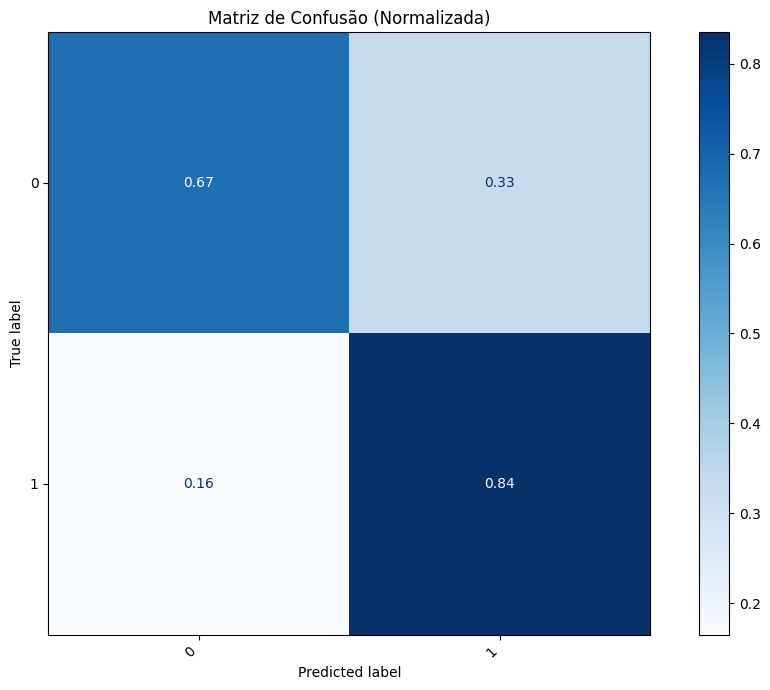

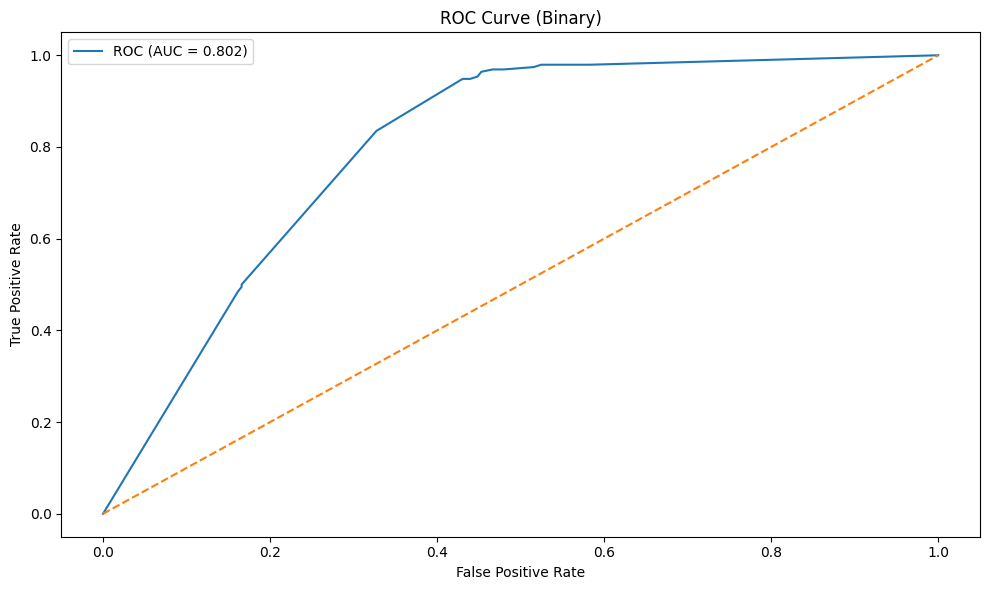


Salvo: modelo_dt.joblib


In [53]:
# Roda a função com modelo: Decision Tree


from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced",
    max_depth=6,
    min_samples_leaf=10,
    min_samples_split=20
)

artefato_dt = treinar_avaliar_salvar("dt", dt, X_train, X_test, y_train, y_test, salvar=True)



Modelo: rf
Acurácia: 0.8897

Classification Report:

              precision    recall  f1-score   support

           0     0.8831    0.9148    0.8987       223
           1     0.8978    0.8608    0.8789       194

    accuracy                         0.8897       417
   macro avg     0.8905    0.8878    0.8888       417
weighted avg     0.8900    0.8897    0.8895       417



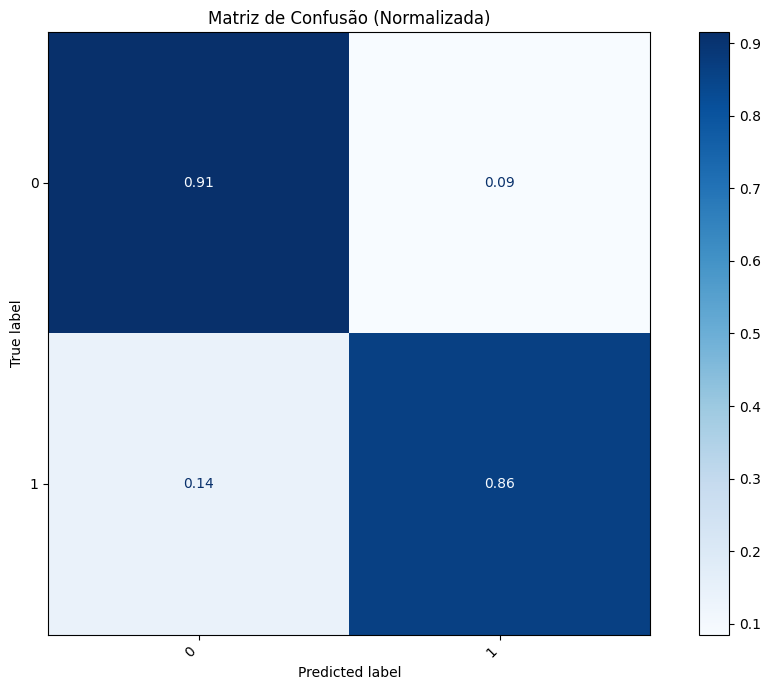

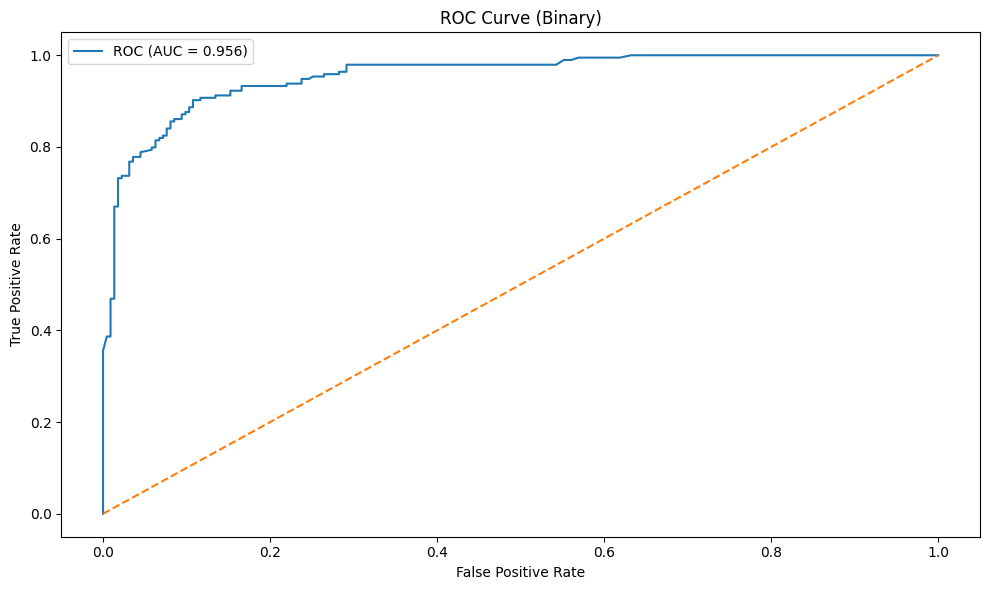


Salvo: modelo_rf.joblib


In [54]:
# Roda a função com o modelo: Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=600,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1,
    max_features="sqrt"
)

artefato_rf = treinar_avaliar_salvar("rf", rf, X_train, X_test, y_train, y_test, salvar=True)



Modelo: gb
Acurácia: 0.8681

Classification Report:

              precision    recall  f1-score   support

           0     0.8962    0.8520    0.8736       223
           1     0.8390    0.8866    0.8622       194

    accuracy                         0.8681       417
   macro avg     0.8676    0.8693    0.8679       417
weighted avg     0.8696    0.8681    0.8683       417



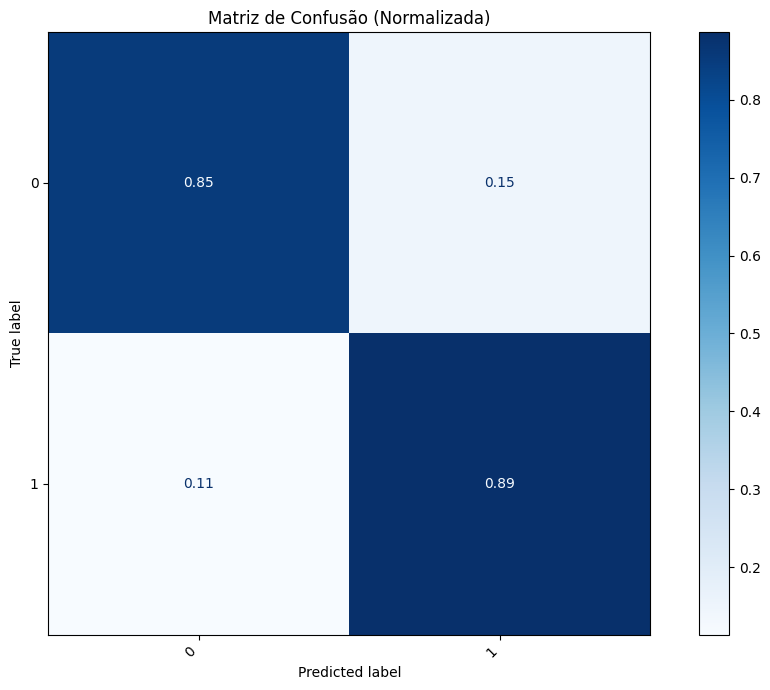

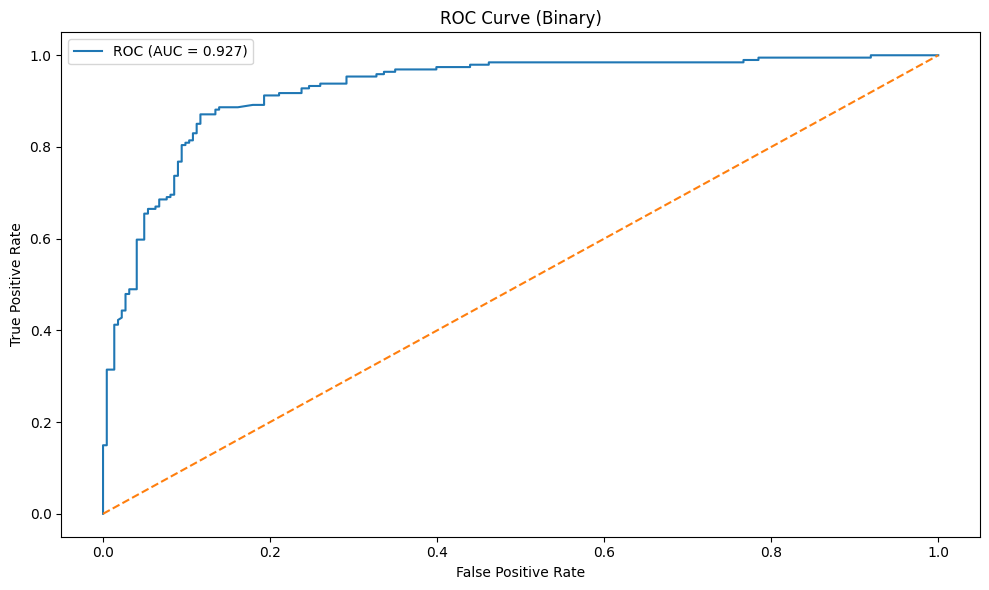


Salvo: modelo_gb.joblib


In [55]:
# Roda a função com o modelo: Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9
)

artefato_gb = treinar_avaliar_salvar("gb", gb, X_train, X_test, y_train, y_test, salvar=True)



Modelo: logreg
Acurácia: 0.7386

Classification Report:

              precision    recall  f1-score   support

           0     0.8519    0.6188    0.7169       223
           1     0.6667    0.8763    0.7572       194

    accuracy                         0.7386       417
   macro avg     0.7593    0.7476    0.7371       417
weighted avg     0.7657    0.7386    0.7357       417



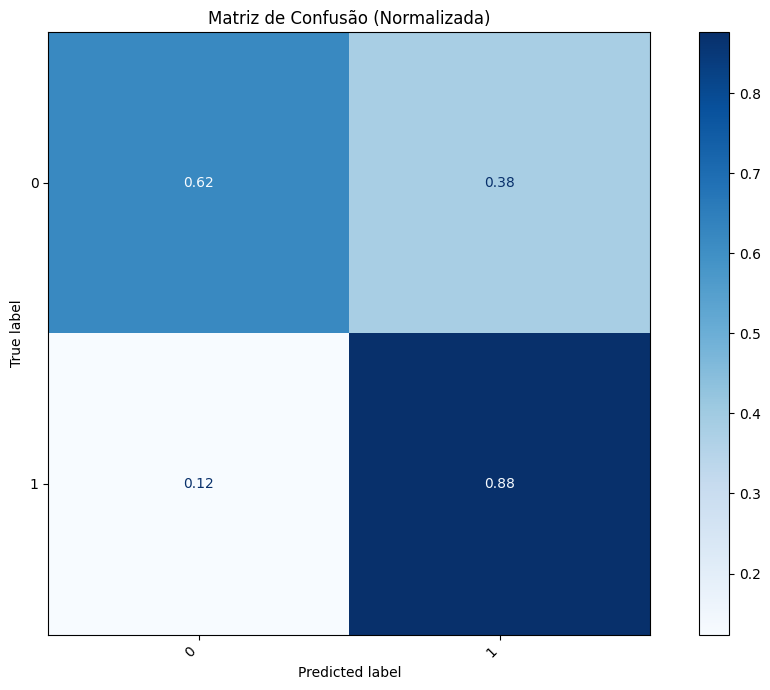

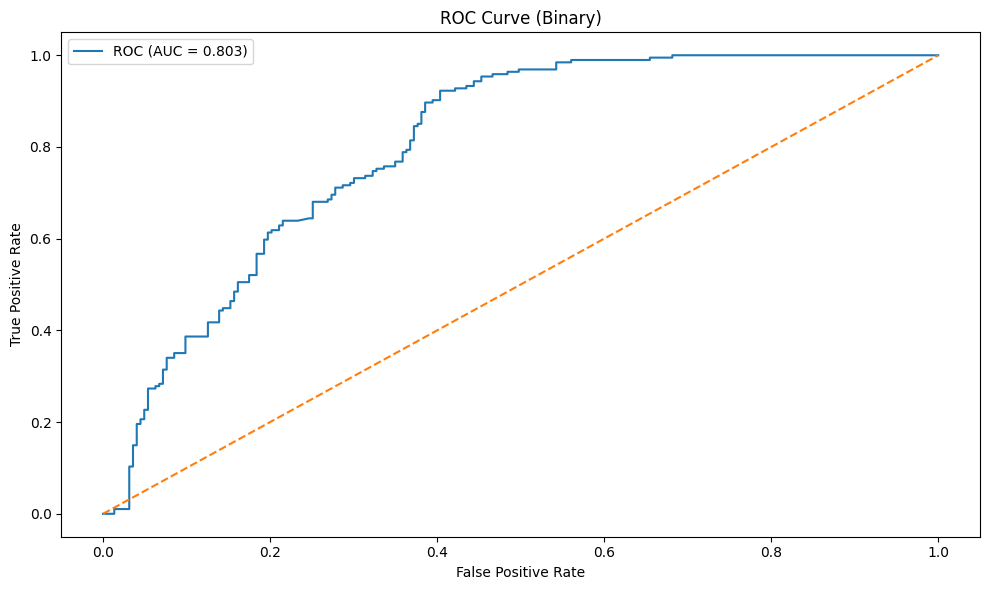


Salvo: modelo_logreg.joblib


In [56]:
# Roda a função com o modelo: Logistic Regression

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    max_iter=3000,
    class_weight="balanced"
)

artefato_logreg = treinar_avaliar_salvar("logreg", logreg, X_train, X_test, y_train, y_test, salvar=True)



Modelo: extra_trees
Acurácia: 0.8777

Classification Report:

              precision    recall  f1-score   support

           0     0.8644    0.9148    0.8889       223
           1     0.8950    0.8351    0.8640       194

    accuracy                         0.8777       417
   macro avg     0.8797    0.8749    0.8764       417
weighted avg     0.8787    0.8777    0.8773       417



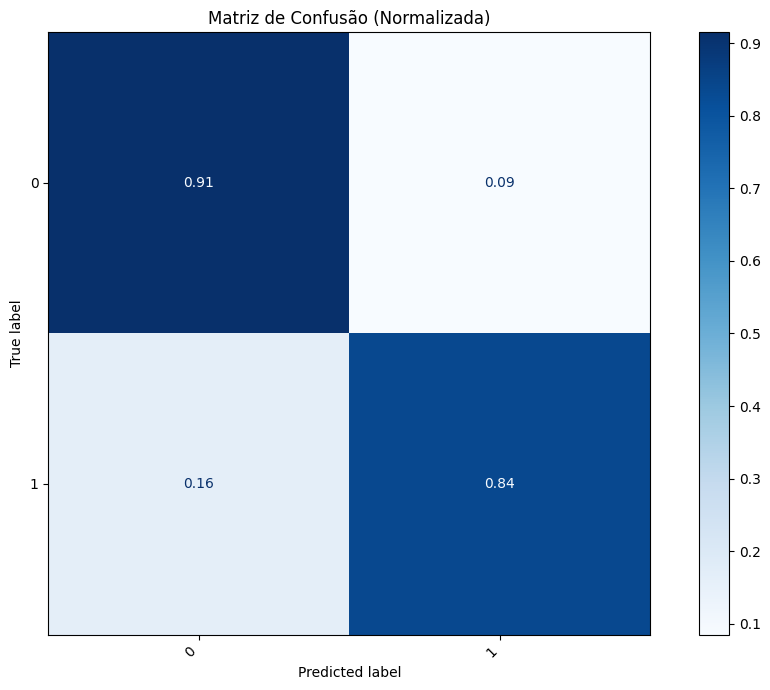

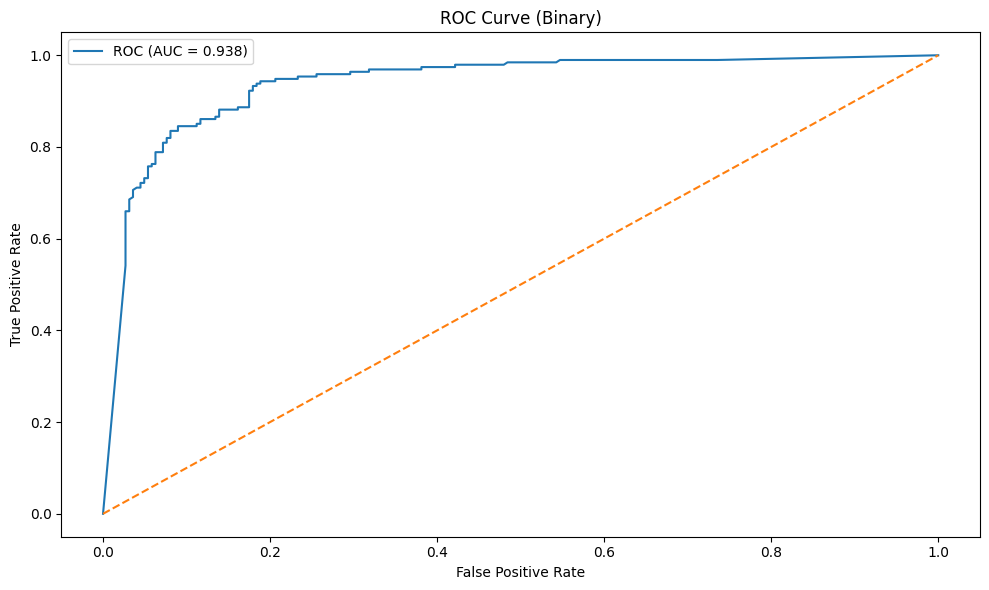


Salvo: modelo_extra_trees.joblib


In [57]:
# Roda a função com o modelo: Extremely Randomized Trees

from sklearn.ensemble import ExtraTreesClassifier

extra = ExtraTreesClassifier(
    n_estimators=800,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1,
    max_features="sqrt"
)

artefato_extra = treinar_avaliar_salvar("extra_trees", extra, X_train, X_test, y_train, y_test, salvar=True)



Modelo: hgb
Acurácia: 0.8897

Classification Report:

              precision    recall  f1-score   support

           0     0.8865    0.9103    0.8982       223
           1     0.8936    0.8660    0.8796       194

    accuracy                         0.8897       417
   macro avg     0.8900    0.8881    0.8889       417
weighted avg     0.8898    0.8897    0.8896       417



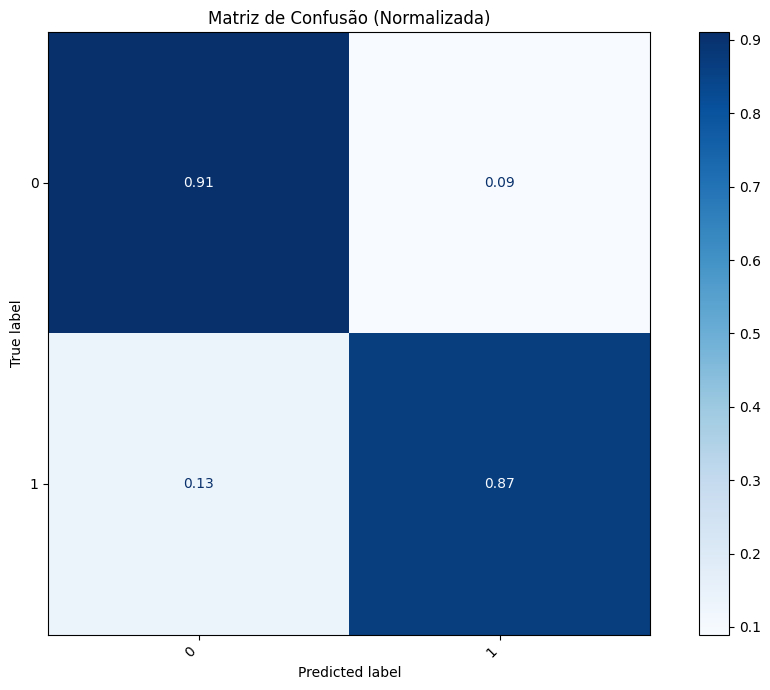

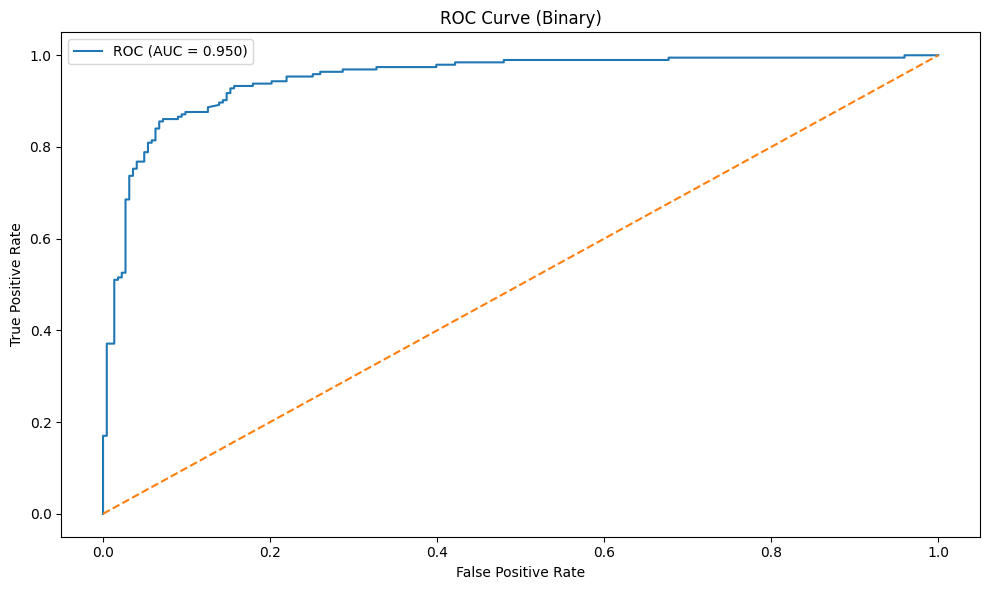


Salvo: modelo_hgb.joblib


In [58]:
# Roda a função com o modelo: HistGradientBoosting

from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(
    random_state=42,
    max_iter=400,
    learning_rate=0.05,
    max_depth=8
)

artefato_hgb = treinar_avaliar_salvar("hgb", hgb, X_train, X_test, y_train, y_test, salvar=True)



Modelo: svc
Acurácia: 0.8609

Classification Report:

              precision    recall  f1-score   support

           0     0.9024    0.8296    0.8645       223
           1     0.8208    0.8969    0.8571       194

    accuracy                         0.8609       417
   macro avg     0.8616    0.8633    0.8608       417
weighted avg     0.8644    0.8609    0.8611       417



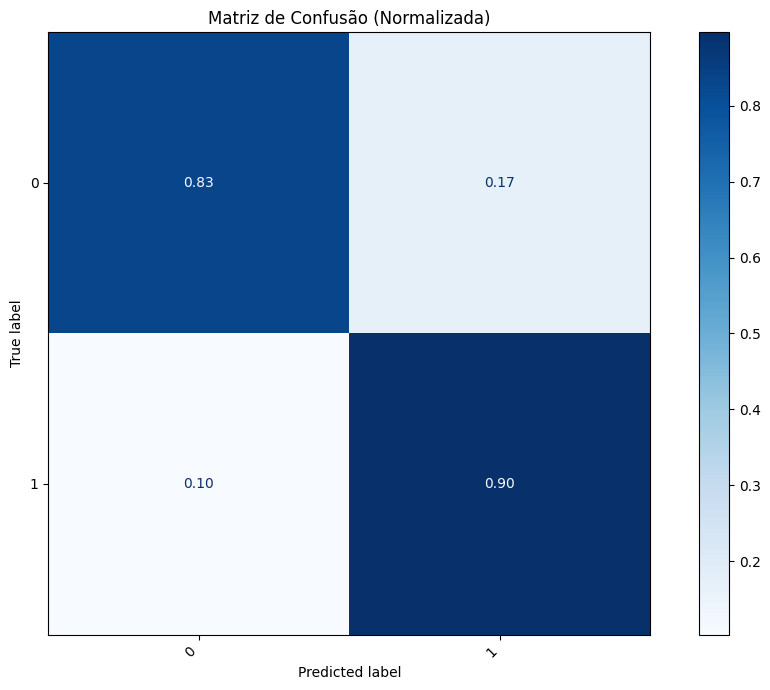

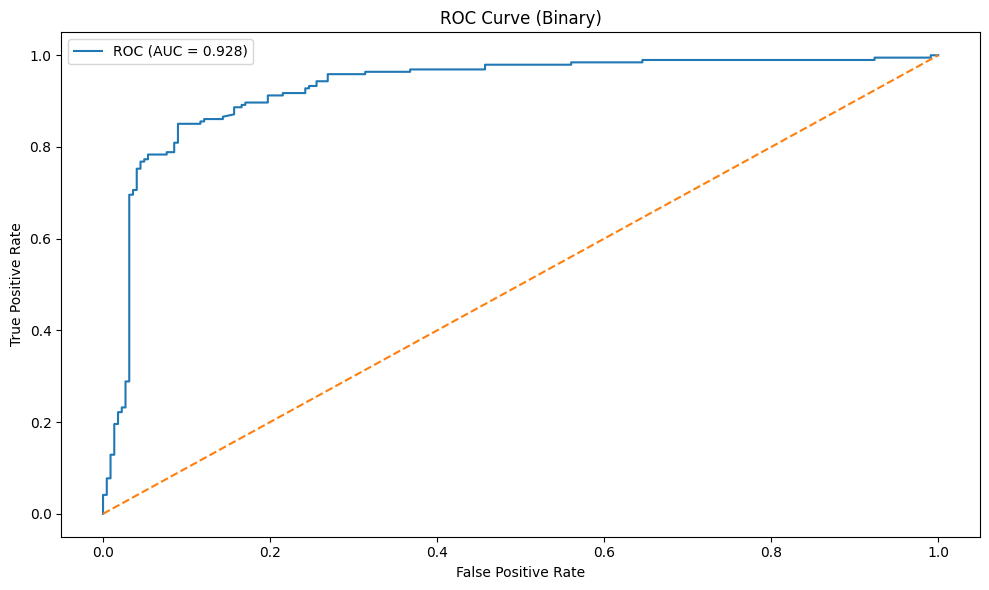


Salvo: modelo_svc.joblib


In [59]:
# Roda a função com o modelo: Support Vector Classifier (SVC) com StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svc = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=3.0, gamma="scale", class_weight="balanced", probability=True, random_state=42))
])

artefato_svc = treinar_avaliar_salvar("svc", svc, X_train, X_test, y_train, y_test, salvar=True)


In [60]:
# Esta função testa vários thresholds (pontos de corte) para transformar a probabilidade do modelo em 0/1.
# Ela escolhe o threshold que melhor equilibra precisão e recall (F1 / balanced accuracy / Youden J).

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix

def escolher_threshold(modelo, X_ref, y_ref, passo=0.01):
    # Probabilidade da classe positiva (1 = obeso)
    proba = modelo.predict_proba(X_ref)[:, 1]

    thresholds = np.arange(0.01, 1.00, passo)

    melhor_f1 = {"thr": None, "f1": -1}
    melhor_balacc = {"thr": None, "balacc": -1}
    melhor_j = {"thr": None, "j": -1}

    linhas = []

    for thr in thresholds:
        y_pred = (proba >= thr).astype(int)

        prec = precision_score(y_ref, y_pred, zero_division=0)
        rec  = recall_score(y_ref, y_pred, zero_division=0)
        f1   = f1_score(y_ref, y_pred, zero_division=0)
        bal  = balanced_accuracy_score(y_ref, y_pred)

        cm = confusion_matrix(y_ref, y_pred, labels=[0,1])
        tn, fp, fn, tp = cm.ravel()

        # TPR = recall; FPR = fp/(fp+tn)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        j = rec - fpr

        linhas.append((thr, prec, rec, f1, bal, j))

        if f1 > melhor_f1["f1"]:
            melhor_f1 = {"thr": thr, "f1": f1, "prec": prec, "rec": rec, "bal": bal, "j": j}

        if bal > melhor_balacc["balacc"]:
            melhor_balacc = {"thr": thr, "balacc": bal, "prec": prec, "rec": rec, "f1": f1, "j": j}

        if j > melhor_j["j"]:
            melhor_j = {"thr": thr, "j": j, "prec": prec, "rec": rec, "f1": f1, "bal": bal}

    print("Melhor por F1:")
    print(melhor_f1)

    print("\nMelhor por Balanced Accuracy:")
    print(melhor_balacc)

    print("\nMelhor por Youden J (TPR - FPR):")
    print(melhor_j)

    # Mostra uns candidatos próximos (top 10 por F1)
    linhas_ordenadas = sorted(linhas, key=lambda x: x[3], reverse=True)[:10]
    print("\nTop 10 thresholds por F1 (thr, precision, recall, f1, bal_acc, youdenJ):")
    for r in linhas_ordenadas:
        print(f"{r[0]:.2f}  prec={r[1]:.3f}  rec={r[2]:.3f}  f1={r[3]:.3f}  bal={r[4]:.3f}  J={r[5]:.3f}")

    return melhor_f1, melhor_balacc, melhor_j


In [61]:
# Calcula, no conjunto de teste, o melhor ponto de corte (threshold) do Random Forest para classificar 0/1 com base em F1, balanced accuracy e Youden J.

best_f1, best_bal, best_j = escolher_threshold(artefato_rf["model"], X_test, y_test)


Melhor por F1:
{'thr': np.float64(0.41000000000000003), 'f1': 0.8905852417302799, 'prec': 0.8793969849246231, 'rec': 0.9020618556701031, 'bal': 0.8972192686422265, 'j': np.float64(0.7944385372844529)}

Melhor por Balanced Accuracy:
{'thr': np.float64(0.41000000000000003), 'balacc': 0.8972192686422265, 'prec': 0.8793969849246231, 'rec': 0.9020618556701031, 'f1': 0.8905852417302799, 'j': np.float64(0.7944385372844529)}

Melhor por Youden J (TPR - FPR):
{'thr': np.float64(0.41000000000000003), 'j': np.float64(0.7944385372844529), 'prec': 0.8793969849246231, 'rec': 0.9020618556701031, 'f1': 0.8905852417302799, 'bal': 0.8972192686422265}

Top 10 thresholds por F1 (thr, precision, recall, f1, bal_acc, youdenJ):
0.41  prec=0.879  rec=0.902  f1=0.891  bal=0.897  J=0.794
0.39  prec=0.871  rec=0.907  f1=0.889  bal=0.895  J=0.791
0.40  prec=0.875  rec=0.902  f1=0.888  bal=0.895  J=0.790
0.42  prec=0.879  rec=0.897  f1=0.888  bal=0.895  J=0.789
0.38  prec=0.863  rec=0.907  f1=0.884  bal=0.891  J=0

## Análise do Threshold (ponto de corte) do Random Forest

### O que este resultado mostra
foram testados vários pontos de corte (0.01 a 0.99) para transformar a probabilidade do modelo em classe:

- Probabilidade ≥ threshold → **1 (obeso)**
- Probabilidade < threshold → **0 (não obeso)**

A função buscou o melhor threshold por três critérios:
- **F1** (equilíbrio entre precision e recall)
- **Balanced Accuracy** (equilíbrio de acerto entre as duas classes)
- **Youden J** (TPR - FPR, separação entre classes)

**objetivo:** definir o melhor ponto de corte (threshold) para transformar a probabilidade do modelo em 0/1, equilibrando acertar os obesos (recall) e não acusar não obesos como obesos (precision).

### Resultado principal (o mais importante)
O threshold **0.41** foi o melhor **ao mesmo tempo** para:
- F1
- Balanced Accuracy
- Youden J

Isso é um ótimo sinal: o ponto de corte escolhido não é “bom por um critério e ruim por outro”; ele ficou consistente nos três.

### Métricas no melhor ponto (threshold = 0.41)
- **Precision (classe 1 = obeso):** 0.879  
  Quando o modelo diz “obeso”, acerta ~87.9% das vezes (menos alarmes falsos).

- **Recall (classe 1 = obeso):** 0.902  
  De todos os obesos reais, ele identifica ~90.2% (deixa poucos obesos passarem).

- **F1:** 0.891  
  Melhor equilíbrio entre precision e recall.

- **Balanced Accuracy:** 0.897  
  Bom equilíbrio no acerto de **obeso** e **não obeso**.

- **Youden J:** 0.794  
  Boa separação entre as classes (alto TPR com FPR controlado).

### Comparação com o padrão 0.50
No threshold padrão **0.50**:
- precision=0.898 (um pouco maior)
- recall=0.861 (pior: deixa mais obesos passarem)
- f1=0.879 (pior que 0.41)
- bal=0.888 (pior que 0.41)

Ou seja: **0.50 é mais conservador** (menos “obeso”), mas perde sensibilidade.

Conforme a necessidade de **evitar falso positivi e evitar que uma pessoa obesa passe como não obesa, usaremos o **threshold = 0.41**, pois ele é o melhor ponto de equilíbrio entre:
* não acusar errado (precision boa)
* não deixar obeso escapar (recall alto)

### Observação 
Se você quisesswe ser mais cauteloso e obter menos falsos positivos, o threshold **0.50** seria aceitável, mas iria perder recall, onde mais obesos passariam como não obesos, o que seria mais prejudicial as analise

## **Implementação a ser inluida no app**

* Modelo: Random Forest
* Ponto de corte: **0.41**
* Saída: classe + probabilidade

**Regra:**
* se `proba >= 0.41` → **Obeso (1)**
* senão → **Não obeso (0)**


In [62]:
# Salva o threshold (0.41) junto do artefato do Random Forest e grava o .joblib em C:\projetos\fase4\models\

artefato_rf["threshold"] = 0.41
joblib.dump(artefato_rf, r"C:\projetos\fase4\models\modelo_rf.joblib")



['C:\\projetos\\fase4\\models\\modelo_rf.joblib']

In [63]:
X.columns


Index(['sexo', 'idade', 'historico_familiar', 'ingere_alim_calorico',
       'ingere_vegetais', 'qtd_refeicao_principal', 'come_entre_refeicao',
       'fumante', 'consumo_agua_litro', 'monitora_calorias',
       'freq_atividade_fisica', 'tempo_uso_eletronico',
       'frequencia_consumo_alcool', 'meio_de_transporte'],
      dtype='object')

In [64]:
art = joblib.load(r"C:\projetos\fase4\models\modelo_rf.joblib")
print(art.keys())


dict_keys(['model', 'feature_columns', 'labels', 'acc', 'auc_macro', 'params', 'threshold'])
